## Dependencies

In [32]:

import os
import numpy as np
#python3 -m pip install tensorflow[and-cuda]
# Verify the installation:
#python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Add, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD



## Converting RGB to Grey

In [ ]:
import cv2
import os

# Specify the input and output folders
input_folder = r"D:\PCOS_Challenge\PCOS_image\healthy"
output_folder = r"D:\PCOS_Challenge\images_new\Healthy"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
     os.makedirs(output_folder)

 # List all files in the input folder
 files = os.listdir(input_folder)

 for file in files:
    # Construct the full path for the input file
     input_path = os.path.join(input_folder, file)

     # Read the image using cv2
     original_image = cv2.imread(input_path)

     # Resize the image to 32x32 pixels
     resized_image = cv2.resize(original_image, (128, 128))

     # Convert the image to grayscale
     grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

     # Construct the full path for the output file
     output_path = os.path.join(output_folder, file)

     # Save the processed image to the output folder
     cv2.imwrite(output_path, grayscale_image)

## Data Augmentation

In [ ]:
try:
    import tensorflow as tf
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    import matplotlib.pyplot as plt
    import os
    from tqdm import tqdm
    from PIL import Image
except ImportError:
    # Install required libraries if not found
    !pip install tensorflow pillow

# Set the seed for reproducibility
tf.random.set_seed(42)

# Define the path to your dataset
original_data_path = r"D:\PCOS_Challenge\images_new\Healthy"

# Define the path to save the augmented dataset
augmented_data_path = r"D:\PCOS_Challenge\Augmented\images_new\Healthy"
os.makedirs(augmented_data_path, exist_ok=True)

# Create an ImageDataGenerator instance with various augmentation techniques
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Iterate through each image in the class
for img_name in tqdm(os.listdir(original_data_path)):
    img_path = os.path.join(original_data_path, img_name)
    img = Image.open(img_path)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch of size 1

    # Generate augmented images and save them
    for i in range(1, 4 + 1):
        augmented_img = datagen.flow(img_array).next()
        augmented_img_name = f"{img_name}_aug_{i}.png"
        augmented_img_path = os.path.join(augmented_data_path, augmented_img_name)
        plt.imsave(augmented_img_path, tf.squeeze(augmented_img)/255.0, cmap = 'gray')

## Splitting dataset

In [7]:

import os
import random
import shutil

def split_data(source_folder, train_folder, val_folder, split_ratio=0.8):
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)

    # List all files in the source folder
    all_files = os.listdir(source_folder)

    # Randomly shuffle the file list
    random.shuffle(all_files)

    # Calculate the number of files for training and validation
    num_train = int(len(all_files) * split_ratio)
    train_files = all_files[:num_train]
    val_files = all_files[num_train:]

    # Move files to the training folder
    for file in train_files:
        source_path = os.path.join(source_folder, file)
        destination_path = os.path.join(train_folder, file)
        shutil.move(source_path, destination_path)

    # Move files to the validation folder
    for file in val_files:
        source_path = os.path.join(source_folder, file)
        destination_path = os.path.join(val_folder, file)
        shutil.move(source_path, destination_path)

# Set the paths for the source "healthy" and "unhealthy" folders

healthy_source_folder = r"C:\Users\reach\Downloads\pcos_clean\images_new\aug_healthy"
unhealthy_source_folder = r"C:\Users\reach\Downloads\pcos_clean\images_new\aug_unhealthy"

# Set the paths for the destination train and validate folders
train_healthy_folder = r"C:\Users\reach\Downloads\pcos_clean\images_new\train\healthy"
val_healthy_folder = r"C:\Users\reach\Downloads\pcos_clean\images_new\validate\healthy"
train_unhealthy_folder = r"C:\Users\reach\Downloads\pcos_clean\images_new\train\unhealthy"
val_unhealthy_folder = r"C:\Users\reach\Downloads\pcos_clean\images_new\validate\unhealthy"

# Split the data for "healthy" images
split_data(healthy_source_folder, train_healthy_folder, val_healthy_folder)

# Split the data for "unhealthy" images
split_data(unhealthy_source_folder, train_unhealthy_folder, val_unhealthy_folder)

print("Data split successfully.")

Data split successfully.


## Prepare training and validation dataset

In [20]:
# define parameters
CLASS_NUM = 2
BATCH_SIZE = 16
EPOCH_STEPS = int(4323/BATCH_SIZE)
IMAGE_SHAPE = (128, 128, 3)
IMAGE_TRAIN = r"C:\Users\reach\Downloads\pcos_clean\images_new\train"
IMAGE_VALID = r"C:\Users\reach\Downloads\pcos_clean\images_new\validate"
MODEL_NAME = r"C:\Users\reach\Downloads\pcos_clean\images_new\Googlenet_inspired_wid_resnet_MODEL"


# prepare data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

'''
test_generator = test_datagen.flow_from_directory(
    directory=r"./test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)'''

generator_main = train_datagen.flow_from_directory(
    IMAGE_TRAIN,
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = train_datagen.flow_from_directory(
    IMAGE_VALID,
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

def my_generator(generator):
    while True: # keras requires all generators to be infinite
        data = next(generator)
        x = data[0]
        y = data[1], data[1], data[1]
        yield x, y

train_generator = my_generator(generator_main)
valid_generator = my_generator(valid_generator)

Found 10239 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


## Creating the Model

In [26]:
# create model

def resnet(x, filters):

    X_shortcut = x
     # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path1 = BatchNormalization()(path1)
    path1 = Activation('relu')(path1)
    
    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path1)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    path2 = BatchNormalization()(path2)
    path2 = Activation('relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path2)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)
    path3 = BatchNormalization()(path3)
    path3 = Activation('relu')(path3)
    
    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(path3)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    X_shortcut = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same')(X_shortcut)
    # Add shortcut value to main path
    X = Add()([X_shortcut, path4])
    X = Activation('relu')(path4)
    
    return X

    


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    
    
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    #layer_in = resnet_50.input
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = Conv2D(filters=96, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    #layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    #layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = resnet(layer, [ 64,  (96,128), (16,32), 32])
    layer = resnet(layer, filters = [128, (128,192), (32,96), 64])
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = Conv2D(filters=96, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    #layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    layer = resnet(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    #layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    #layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    #layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    layer = Conv2D(filters=112, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = resnet(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = resnet(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = resnet(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    #layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    #layer = Conv2D(filters=320, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = resnet(layer, [256, (160,320), (32,128), 128])
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    layer = AveragePooling2D(pool_size=(7,7), strides=(1, 1), padding='same')(layer)

    #layer = resnet_50.output
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model



In [30]:
# train model
model = googlenet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_114 (Conv2D)         (None, 64, 64, 64)           9472      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_22 (MaxPooli  (None, 32, 32, 64)           0         ['conv2d_114[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 batch_normalization_46 (Ba  (None, 32, 32, 64)           256       ['max_pooling2d_22[0][0]

## Train the Model

In [93]:
optimizer = ['Adam', 'SGD', 'Adam', 'SGD']
epochs = [20,30,20,30]
history_all = {}

for i in range(len(optimizer)):
    print('Usnig optimizer: ' + optimizer[i] + ', Epoch: ' + str(epochs[i]))
    
    model.compile(loss='categorical_crossentropy', 
                  loss_weights={'main': 1.0,'aux1': 0.3, 'aux2': 0.3},
                  optimizer=optimizer[i], metrics=['accuracy'])
    
    train_history = model.fit_generator(
            train_generator,
            steps_per_epoch=EPOCH_STEPS,
            epochs=epochs[i],
            #callbacks=[checkpoint]
            shuffle=True
            )
    
    # save history    
    if len(history_all) == 0:
        history_all = {key: [] for key in train_history.history}
    
    for key in history_all:
        history_all[key].extend(train_history.history[key])

Usnig optimizer: Adam, Epoch: 20
Epoch 1/20


C:\Users\User\AppData\Local\Temp\ipykernel_45808\444723203.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  train_history = model.fit_generator(


270/270 [==============================] - 46s 137ms/step - loss: 1.1986 - main_loss: 0.8148 - aux1_loss: 0.6392 - aux2_loss: 0.6402 - main_accuracy: 0.7023 - aux1_accuracy: 0.6903 - aux2_accuracy: 0.6991
Epoch 2/20
270/270 [==============================] - 40s 147ms/step - loss: 0.9631 - main_loss: 0.5988 - aux1_loss: 0.6052 - aux2_loss: 0.6092 - main_accuracy: 0.7147 - aux1_accuracy: 0.7087 - aux2_accuracy: 0.7131
Epoch 3/20
270/270 [==============================] - 40s 149ms/step - loss: 0.9541 - main_loss: 0.5956 - aux1_loss: 0.5977 - aux2_loss: 0.5975 - main_accuracy: 0.7206 - aux1_accuracy: 0.7192 - aux2_accuracy: 0.7201
Epoch 4/20
270/270 [==============================] - 38s 142ms/step - loss: 0.9590 - main_loss: 0.5996 - aux1_loss: 0.5967 - aux2_loss: 0.6011 - main_accuracy: 0.7157 - aux1_accuracy: 0.7146 - aux2_accuracy: 0.7141
Epoch 5/20
270/270 [==============================] - 38s 142ms/step - loss: 0.9503 - main_loss: 0.5941 - aux1_loss: 0.5915 - aux2_loss: 0.5959 - m

## Performance

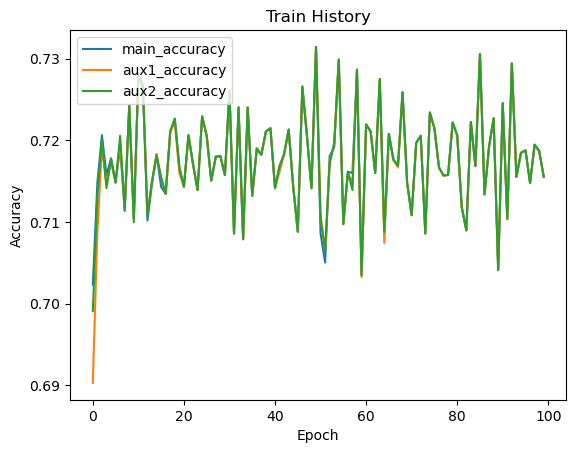

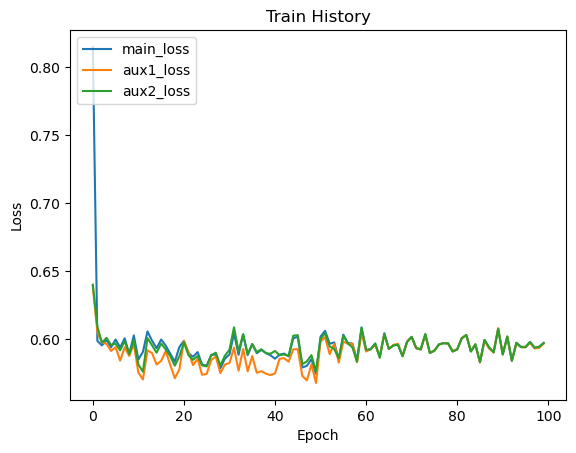

In [94]:
# show train history
def show_train_history(history, xlabel, ylabel, train):
    for item in train:
        plt.plot(history[item])
    plt.title('Train History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

show_train_history(history_all, 'Epoch', 'Accuracy', ('main_accuracy', 'aux1_accuracy', 'aux2_accuracy'))
show_train_history(history_all, 'Epoch', 'Loss', ('main_loss', 'aux1_loss', 'aux2_loss'))

## Saving the model

In [12]:
MODEL_NAME = r"C:\Users\reach\Downloads\pcos_clean\images_new\Googlenet_inspired_wid_resnet_MODEL"

In [105]:
model.save(MODEL_NAME)

INFO:tensorflow:Assets written to: D:\PCOS_Challenge\Augmented\model\assets


INFO:tensorflow:Assets written to: D:\PCOS_Challenge\Augmented\model\assets


In [29]:
model.load_weights(MODEL_NAME)

## Test the model

In [37]:
'''model_path = './Googlenet_inspired_wid_resnet_MODEL'
'''

from tensorflow.keras.models import load_model
# Load the model
model = load_model(MODEL_NAME)


# test the model
#IMAGE_TEST = r"D:/data_split_excelsheet/PCOS_test/converted_gray"
VALID = r"C:\Users\reach\Downloads\pcos_clean\images_new\validate1\validate1"


# Prepare test data generator
valid1_datagen = ImageDataGenerator()  # Apply same rescaling as training data

val_generator = valid1_datagen.flow_from_directory(
    VALID,
    target_size=(128, 128),
    batch_size=60,
    class_mode='categorical',
    shuffle=True,
    seed=42
)


#train_generator = my_generator(generator_main)
#valid_generator = my_generator(valid_generator)
#test_generator = my_generator(test_generator)


prediction = model.evaluate(val_generator)
prediction

Found 2561 images belonging to 2 classes.
20/43 [============>.................] - ETA: 7s - loss: 0.9721 - main_loss: 0.6069 - aux1_loss: 0.6102 - aux2_loss: 0.6070 - main_accuracy: 0.7050 - aux1_accuracy: 0.7050 - aux2_accuracy: 0.7050

KeyboardInterrupt: 

## Interpretibility

In [106]:
!pip install lime

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         x_train[10], 
         model.predict
)
plt.imshow(x_train[10]) 